In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tqdm as progressbar
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

## Models

In [2]:
## phi = sin(x)sin(y)
## 5 or more with relu
## More layers for resnet
## make sure to introduce dropout lyers fro generalization and make sure to initialize the weights correctly
## xaviar distribution for initialization or gaussian.
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        # m.bias.data.fill_(0.01)

class Res(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Res, self).__init__()
        ## Layer initialization
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout1 = nn.Dropout(0.5)

        ## weight initialization
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)


    def forward(self, x):
        x1 = torch.tanh(self.fc1(x))
        x2 = torch.tanh(self.dropout1(self.fc2(x1)))
        x3 = self.fc3(x2 + x1)
        return x3

class SimplestNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimplestNeuralNetwork, self).__init__()
        ## Layer initialization
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

        ## weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):
        x1 = nn.functional.relu(self.fc1(x))
        x5 = self.fc5(x1)
        return x5

class SimpleReluNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleReluNet, self).__init__()
        ## Layer initialization
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.25)

        ## weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):
        x1 = nn.functional.relu(self.fc1(x))
        x2 = nn.functional.relu(self.dropout1(self.fc2(x1)))
        x3 = nn.functional.relu(self.fc3(x2))
        x4 = nn.functional.relu(self.dropout2(self.fc4(x3)))
        x5 = self.fc5(x4)
        return x5

class GeneralReLuNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(GeneralReLuNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                if torch.rand() < 0.1:
                    print(f"Dropout at layer {i}")
                    layers.append(nn.Dropout(0.25 + torch.rand()/4))
                layers.append(nn.ReLu())
        self.network = nn.Sequential(*layers)
        self.network.apply(init_weights)

    def forward(self, x):
        return self.network(x)

## sin_prod

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class PDEDataset(Dataset):
    def __init__(self, x_gr):
        self.x = x_gr
        self.y = pde_rhs(self.x)  # Assign the entire tensor at once
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def create_dataset(x_gr):
    dataset = PDEDataset(x_gr)
    return dataset

def phi(x : torch.tensor) -> torch.tensor:
    return torch.prod(torch.sin(x), dim = 0)

def q(x : torch.tensor) -> torch.tensor:
    return torch.ones(x.shape, device = device)

def p(x : torch.tensor) -> torch.tensor:
    sum_cos = torch.cos(torch.sum(x, dim = 1)).to(device)
    sinx = torch.sin(x)
    cosx = torch.cos(x)
    t = torch.stack((cosx[:, 0]*sinx[:, 1], sinx[:, 0]*cosx[:, 1]), dim = 1).to(device)
    return sum_cos.reshape(-1, 1) + 1 - 2*t

def plot_contour(func, title = "Contour plot for phi(x) = sin(x)sin(y)"):
    x = torch.linspace(0,2*torch.pi, 200)
    X,Y = torch.meshgrid(x, x)
    Z = torch.empty_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(torch.tensor([X[i, j], Y[i, j]]))
    plt.contourf(X, Y, Z)
    plt.colorbar()
    plt.title(title)
    plt.show()


def pde_rhs(x):
    with torch.no_grad():
        rhs = p(x) - q(x)
    return rhs

# plot_contour(phi)

num_samples = 2500
dim = 2
x_max = 2*torch.pi
x_min = 0
x_gr = torch.rand(num_samples, 2) * (abs(x_max) + abs(x_min)) + x_min
dataset = create_dataset(x_gr)
# torch.save(dataset, f"dataset_sin_{num_samples}.pth")


In [7]:
dataset

## training loop

In [7]:
# fc + residual block
def pde(tar_sc , model, x):
    x= x.requires_grad_(True)  # Create a separate variable for use in this function
    dy = lambda p : torch.func.jacrev(model)(p).squeeze()
    return dy(x)
    # dy_dotq = lambda x : torch.dot(dy(x), tar_sc(x)).to(device)
    # d_dy_dotq = torch.func.jacrev(dy_dotq)
    # divergence_dy = lambda x : torch.trace(torch.func.jacrev(dy)(x)).to(device)
    # d_divergence_dy = torch.func.jacrev(divergence_dy)
    # pde_lhs = d_divergence_dy(x) + d_dy_dotq(x)
    # return pde_lhs

## remains to fix
def train_pde(model, tar_sc, dataloader, optimizer, batchsize, device, epochs=10):
    loss_list = []
    print("Training the model...")
    with progressbar.tqdm (range(epochs), unit="epoch") as pbar:
        output = torch.empty((batchsize, 2), device = device)
        for epoch in range(epochs):
            # optimizer.zero_grad()
            for t, (x, y) in enumerate(dataloader):
                optimizer.zero_grad()
                x_g = x.to(device)
                y_g = y.to(device)
                new_output = torch.empty_like(output)
                for i, x_i in enumerate(x_g):
                    x_out = x_i.detach().clone()
                    new_output[i] = pde(tar_sc, model, x_out)
                output = new_output
                pde_loss = torch.nn.functional.mse_loss(output, y_g.float())
                # loss = pde_loss
                print("loss:", pde_loss.item())
                pde_loss.backward()
                optimizer.step()
            pbar.update()
            loss_list.append(pde_loss.item())
    return loss_list

def solve_newton_step_pinn(tar_sc, lr, batchsize, device, num_train, num_test, model_type, epochs=25):
    if model_type == "res":
        model = Res(input_dim=2, hidden_dim=50, output_dim=1)
    elif model_type == "general":
        model = GeneralReLuNet(input_size = 2, hidden_sizes = [50, 50, 64, 25], output_size = 1)
    else:
        model = SimpleReluNet(2, 50, 1)
    model = model.to(device)
    x_max = 2*torch.pi
    x_min = 0
    ## train
    x_gr = torch.rand(num_train, 2) * (abs(x_max) + abs(x_min)) + x_min
    train_dataset = create_dataset(x_gr)
    train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_lst = train_pde(model, tar_sc, train_dataloader, optimizer, batchsize, device, epochs)
    return model, loss_lst

## tbd
def test_model(model, num_test):
    ## test
    x_gr = torch.rand(num_test, 2) * (abs(x_max) + abs(x_min)) + x_min
    test_dataset = create_dataset(x_gr)
    model.eval()
    with torch.no_grad():
        model_predictions = model(x_gr).cpu().numpy().flatten()

In [8]:
model, loss = solve_newton_step_pinn(q, 0.01, 100, "cuda", 2000, 1000, "", epochs = 15)

Training the model...


  0%|          | 0/15 [00:00<?, ?epoch/s]

loss: 1.4791332483291626
loss: 1.539921522140503
loss: 1.4324160814285278
loss: 1.6171249151229858
loss: 1.4130779504776
loss: 1.4221967458724976
loss: 1.4408432245254517
loss: 1.3504198789596558
loss: 1.342481017112732
loss: 1.269850492477417
loss: 1.3638094663619995
loss: 1.3536361455917358
loss: 1.2150617837905884
loss: 1.2727388143539429
loss: 1.3294999599456787
loss: 1.3391653299331665
loss: 1.262556791305542
loss: 1.1521031856536865
loss: 1.3724215030670166


  7%|▋         | 1/15 [00:06<01:37,  6.96s/epoch]

loss: 1.2234234809875488
loss: 1.1534621715545654
loss: 1.1455483436584473
loss: 1.165202260017395
loss: 0.996770441532135
loss: 1.1385496854782104
loss: 1.1233580112457275
loss: 1.2432724237442017
loss: 1.2554961442947388
loss: 1.2073688507080078
loss: 1.1699683666229248
loss: 1.2462440729141235
loss: 1.4095284938812256
loss: 1.3429898023605347
loss: 1.289027214050293
loss: 1.071795105934143
loss: 1.1014147996902466
loss: 1.2693049907684326
loss: 1.2143349647521973
loss: 1.3203985691070557


 13%|█▎        | 2/15 [00:13<01:29,  6.92s/epoch]

loss: 1.340036153793335
loss: 1.1394786834716797
loss: 1.212632417678833
loss: 1.3763009309768677
loss: 1.2805041074752808
loss: 1.127474069595337
loss: 1.2387800216674805
loss: 1.2747889757156372
loss: 1.2622343301773071
loss: 1.2327837944030762
loss: 1.0281901359558105
loss: 1.1306424140930176
loss: 1.1733286380767822
loss: 0.976184606552124
loss: 1.0932650566101074
loss: 1.0336461067199707
loss: 1.133914828300476
loss: 1.0057646036148071
loss: 1.1227097511291504
loss: 1.0039515495300293


 20%|██        | 3/15 [00:20<01:22,  6.87s/epoch]

loss: 1.100926160812378
loss: 1.1365286111831665
loss: 1.278207540512085
loss: 1.2164859771728516
loss: 1.1249802112579346
loss: 1.1892672777175903
loss: 1.0572969913482666
loss: 1.2587716579437256
loss: 1.0994343757629395
loss: 0.9976434111595154
loss: 1.1571232080459595
loss: 1.0590670108795166
loss: 1.239558219909668
loss: 1.0431890487670898
loss: 1.1712815761566162
loss: 1.1715391874313354
loss: 1.1997896432876587
loss: 1.125423550605774
loss: 1.2017940282821655
loss: 1.0923620462417603


 27%|██▋       | 4/15 [00:27<01:15,  6.85s/epoch]

loss: 1.1121691465377808
loss: 1.0699595212936401
loss: 1.111196756362915
loss: 1.0329515933990479
loss: 1.23362398147583
loss: 1.0691332817077637
loss: 1.0460418462753296
loss: 1.0166032314300537
loss: 1.1703451871871948
loss: 1.052316665649414
loss: 1.1403758525848389
loss: 1.095450520515442
loss: 1.1377768516540527
loss: 1.0798529386520386
loss: 1.133475422859192
loss: 1.2274532318115234
loss: 1.2044792175292969
loss: 1.2508699893951416
loss: 1.0685955286026
loss: 1.2286708354949951


 33%|███▎      | 5/15 [00:34<01:08,  6.89s/epoch]

loss: 1.3022228479385376
loss: 1.0797770023345947
loss: 1.1220262050628662
loss: 0.935564398765564
loss: 1.1309993267059326
loss: 1.167120337486267
loss: 1.1052732467651367
loss: 1.0506346225738525
loss: 1.2817906141281128
loss: 1.1601204872131348
loss: 1.118587851524353
loss: 1.1684945821762085
loss: 1.2391330003738403
loss: 1.069985270500183
loss: 0.9678195118904114
loss: 1.081807017326355
loss: 1.0448986291885376
loss: 1.0883700847625732
loss: 0.9261071681976318
loss: 0.9895051121711731


 40%|████      | 6/15 [00:41<01:02,  6.90s/epoch]

loss: 1.1932021379470825
loss: 1.2893208265304565
loss: 1.009392499923706
loss: 1.0690772533416748
loss: 1.177471399307251
loss: 1.2078959941864014
loss: 1.019088864326477
loss: 1.2752275466918945
loss: 1.0869022607803345
loss: 1.1307976245880127
loss: 1.077060580253601
loss: 1.2068986892700195
loss: 1.0707321166992188
loss: 0.9430668950080872
loss: 1.0652748346328735
loss: 0.9673764109611511
loss: 0.8757362365722656
loss: 1.0409210920333862
loss: 0.9503280520439148
loss: 1.039253830909729


 47%|████▋     | 7/15 [00:48<00:56,  7.05s/epoch]

loss: 1.0523707866668701
loss: 1.1030077934265137
loss: 1.1588971614837646
loss: 1.1686575412750244
loss: 1.112080693244934
loss: 1.1055537462234497
loss: 1.0315932035446167
loss: 1.0918327569961548
loss: 1.026145577430725
loss: 0.9296804070472717
loss: 1.056378960609436
loss: 0.9703168272972107
loss: 0.8801318407058716
loss: 0.9599116444587708
loss: 1.046126127243042
loss: 1.1308530569076538
loss: 1.1398195028305054
loss: 1.0790314674377441
loss: 1.249052882194519
loss: 1.2267109155654907


 53%|█████▎    | 8/15 [00:55<00:48,  6.98s/epoch]

loss: 0.9613430500030518
loss: 0.9576330184936523
loss: 1.1099724769592285
loss: 0.930068850517273
loss: 1.0556838512420654
loss: 1.1117159128189087
loss: 0.9890614748001099
loss: 1.0371562242507935
loss: 1.1458683013916016
loss: 0.9320030808448792
loss: 1.218284249305725
loss: 1.0435023307800293
loss: 1.2002145051956177
loss: 1.0311897993087769
loss: 1.022002935409546
loss: 0.9687108993530273
loss: 0.8833776712417603
loss: 1.115992546081543
loss: 0.9797959923744202
loss: 0.9507166743278503


 60%|██████    | 9/15 [01:02<00:41,  6.94s/epoch]

loss: 1.0402182340621948
loss: 1.0844745635986328
loss: 1.031782865524292
loss: 0.9668720960617065
loss: 1.0178089141845703
loss: 1.0571396350860596
loss: 1.0256084203720093
loss: 0.9988343119621277
loss: 1.0800323486328125
loss: 1.1492308378219604
loss: 1.2305973768234253
loss: 1.1768920421600342
loss: 1.2272924184799194
loss: 0.9822854995727539
loss: 1.0931191444396973
loss: 0.9326554536819458
loss: 0.9440457224845886
loss: 1.0593326091766357
loss: 1.0648634433746338
loss: 1.0853519439697266


 67%|██████▋   | 10/15 [01:09<00:34,  6.92s/epoch]

loss: 1.0418665409088135
loss: 1.0263513326644897
loss: 0.9248969554901123
loss: 1.0334616899490356
loss: 0.9542114734649658
loss: 1.1359374523162842
loss: 1.2439059019088745
loss: 1.3018903732299805
loss: 1.0619486570358276
loss: 1.025156855583191
loss: 1.0568751096725464
loss: 1.0255489349365234
loss: 1.1259002685546875
loss: 1.0017069578170776
loss: 0.99151211977005
loss: 0.9666111469268799
loss: 1.0889573097229004
loss: 1.08375084400177
loss: 0.9265512824058533
loss: 1.0321720838546753


 73%|███████▎  | 11/15 [01:16<00:27,  6.90s/epoch]

loss: 0.9533869624137878
loss: 1.0071274042129517
loss: 0.9664546251296997
loss: 1.1282737255096436
loss: 1.1994140148162842
loss: 1.0692942142486572
loss: 1.1551874876022339
loss: 1.021449089050293
loss: 1.0838685035705566
loss: 1.1126490831375122
loss: 1.0815050601959229
loss: 1.161361575126648
loss: 1.0346063375473022
loss: 1.1831872463226318
loss: 1.0066856145858765
loss: 0.9093318581581116
loss: 1.0146582126617432
loss: 0.9001756310462952
loss: 1.0377357006072998
loss: 1.0559667348861694


 80%|████████  | 12/15 [01:23<00:20,  6.91s/epoch]

loss: 1.1518536806106567
loss: 0.9898783564567566
loss: 1.112060546875
loss: 1.0919764041900635
loss: 1.0644563436508179
loss: 1.0521119832992554
loss: 1.028640866279602
loss: 0.959228515625
loss: 1.0645182132720947
loss: 1.2361119985580444
loss: 1.1253952980041504
loss: 1.1790803670883179
loss: 1.288197636604309
loss: 0.9252292513847351
loss: 0.9703072309494019
loss: 0.9687536358833313
loss: 0.996719479560852
loss: 0.9772598743438721
loss: 0.8696250915527344
loss: 1.046124815940857


 87%|████████▋ | 13/15 [01:29<00:13,  6.89s/epoch]

loss: 0.9993528723716736
loss: 1.1782493591308594
loss: 0.9901949167251587
loss: 1.1868723630905151
loss: 1.093740463256836
loss: 1.1801023483276367
loss: 1.0873043537139893
loss: 1.0538389682769775
loss: 1.1969445943832397
loss: 1.1696826219558716
loss: 1.2562141418457031
loss: 1.1865910291671753
loss: 1.036299705505371
loss: 1.1380188465118408
loss: 0.9815673828125
loss: 1.043839454650879
loss: 1.1171479225158691
loss: 1.043370008468628
loss: 1.0067569017410278
loss: 1.0576581954956055


 93%|█████████▎| 14/15 [01:36<00:06,  6.89s/epoch]

loss: 1.1054203510284424
loss: 1.1132186651229858
loss: 1.10638427734375
loss: 1.1267821788787842
loss: 1.1208105087280273
loss: 1.3165655136108398
loss: 1.0829565525054932
loss: 1.121934413909912
loss: 1.2286832332611084
loss: 1.020736575126648
loss: 1.122074007987976
loss: 1.0717617273330688
loss: 1.0805004835128784
loss: 1.0016236305236816
loss: 0.9044838547706604
loss: 0.9780803322792053
loss: 1.0678588151931763
loss: 0.9665073752403259
loss: 1.1490534543991089
loss: 1.129833698272705


100%|██████████| 15/15 [01:43<00:00,  6.91s/epoch]

loss: 1.2053556442260742


In [9]:
print(loss)

[1.2234234809875488, 1.340036153793335, 1.100926160812378, 1.1121691465377808, 1.3022228479385376, 1.1932021379470825, 1.0523707866668701, 0.9613430500030518, 1.0402182340621948, 1.0418665409088135, 0.9533869624137878, 1.1518536806106567, 0.9993528723716736, 1.1054203510284424, 1.2053556442260742]


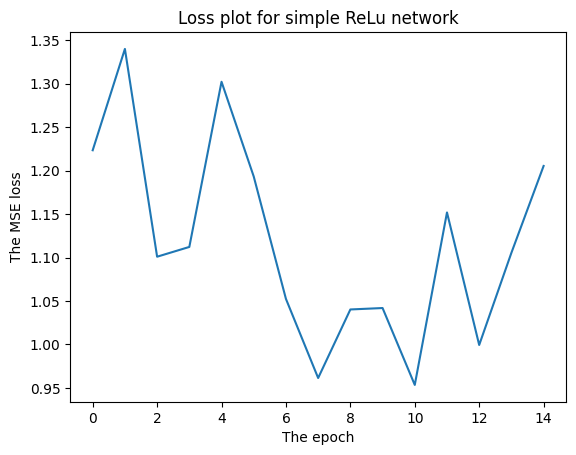

In [10]:
plt.plot(loss)
plt.title("Loss plot for simple ReLu network")
plt.xlabel("The epoch")
plt.ylabel("The MSE loss")
plt.show()

In [13]:
model_res, loss_res = solve_newton_step_pinn(q, 0.01, 100, "cuda", 2000, 1000, "res", epochs = 15)

Training the model...


  0%|          | 0/15 [00:00<?, ?epoch/s]

loss: 1.5772310495376587
loss: 1.5770260095596313
loss: 1.4638371467590332
loss: 1.4650331735610962
loss: 1.4927489757537842
loss: 1.416248083114624
loss: 1.3667136430740356
loss: 1.271406650543213
loss: 1.3158624172210693
loss: 1.3267099857330322
loss: 1.0852285623550415
loss: 1.1278268098831177
loss: 1.041999340057373
loss: 1.0457857847213745
loss: 1.0215662717819214
loss: 1.0258049964904785
loss: 1.147706151008606
loss: 0.9835644364356995
loss: 0.9437332153320312


  7%|▋         | 1/15 [00:04<01:08,  4.89s/epoch]

loss: 0.9315542578697205
loss: 0.9035456776618958
loss: 0.951833188533783
loss: 0.9158675670623779
loss: 0.9343723654747009
loss: 0.8037973642349243
loss: 0.8242032527923584
loss: 0.8824029564857483
loss: 0.904312789440155
loss: 0.726929783821106
loss: 0.7074315547943115
loss: 0.7264887690544128
loss: 0.7838526964187622
loss: 0.6778684854507446
loss: 0.7642077207565308
loss: 0.719798743724823
loss: 0.5931271910667419
loss: 0.6904734373092651
loss: 0.5920607447624207
loss: 0.5564704537391663


 13%|█▎        | 2/15 [00:09<01:04,  4.99s/epoch]

loss: 0.6375546455383301
loss: 0.6255304217338562
loss: 0.6139839887619019
loss: 0.6107208132743835
loss: 0.7078977823257446
loss: 0.5417033433914185
loss: 0.5725096464157104
loss: 0.47603029012680054
loss: 0.6304563283920288
loss: 0.49876663088798523
loss: 0.5588271021842957
loss: 0.5245917439460754
loss: 0.5220908522605896
loss: 0.5356670022010803
loss: 0.5976094007492065
loss: 0.4545400142669678
loss: 0.4245574176311493
loss: 0.5287938714027405
loss: 0.45485350489616394
loss: 0.3086725175380707


 20%|██        | 3/15 [00:14<00:59,  4.95s/epoch]

loss: 0.47509002685546875
loss: 0.46026313304901123
loss: 0.44395124912261963
loss: 0.4353090226650238
loss: 0.39168548583984375
loss: 0.356350839138031
loss: 0.4781709313392639
loss: 0.3656167984008789
loss: 0.448242723941803
loss: 0.5855598449707031
loss: 0.3363110423088074
loss: 0.4385935962200165
loss: 0.4453614056110382
loss: 0.38928118348121643
loss: 0.4288960099220276
loss: 0.36330291628837585
loss: 0.333783894777298
loss: 0.4602477252483368
loss: 0.3729056417942047
loss: 0.41543129086494446


 27%|██▋       | 4/15 [00:19<00:53,  4.89s/epoch]

loss: 0.3289172947406769
loss: 0.4794158935546875
loss: 0.2623105049133301
loss: 0.34546560049057007
loss: 0.4340990483760834
loss: 0.37196648120880127
loss: 0.33353590965270996
loss: 0.4052478075027466
loss: 0.39479300379753113
loss: 0.37811723351478577
loss: 0.41100189089775085
loss: 0.3945484757423401
loss: 0.3029775023460388
loss: 0.28346168994903564
loss: 0.33396971225738525
loss: 0.441922128200531
loss: 0.32520514726638794
loss: 0.3625233471393585
loss: 0.36335456371307373
loss: 0.3401710093021393


 33%|███▎      | 5/15 [00:24<00:48,  4.87s/epoch]

loss: 0.2979752719402313
loss: 0.30949920415878296
loss: 0.31504106521606445
loss: 0.2724948823451996
loss: 0.2868202030658722
loss: 0.24476493895053864
loss: 0.3422083854675293
loss: 0.3320094347000122
loss: 0.2870804965496063
loss: 0.3242642283439636
loss: 0.3855482339859009
loss: 0.33708328008651733
loss: 0.3359847962856293
loss: 0.3676512539386749
loss: 0.3441407084465027
loss: 0.2565692365169525
loss: 0.23562978208065033
loss: 0.27712398767471313
loss: 0.27532750368118286
loss: 0.23001961410045624


 40%|████      | 6/15 [00:29<00:43,  4.88s/epoch]

loss: 0.2914176881313324
loss: 0.2709499001502991
loss: 0.258646696805954
loss: 0.24119973182678223
loss: 0.2661868929862976
loss: 0.28418833017349243
loss: 0.3517487347126007
loss: 0.3053552508354187
loss: 0.26006385684013367
loss: 0.2780008614063263
loss: 0.22815783321857452
loss: 0.36038920283317566
loss: 0.28147605061531067
loss: 0.3628363609313965
loss: 0.2788960635662079
loss: 0.29944199323654175
loss: 0.3235800862312317
loss: 0.22216445207595825
loss: 0.25493574142456055
loss: 0.3250613212585449


 47%|████▋     | 7/15 [00:34<00:38,  4.86s/epoch]

loss: 0.25591447949409485
loss: 0.3169559836387634
loss: 0.28733932971954346
loss: 0.3590506315231323
loss: 0.29483991861343384
loss: 0.3653548061847687
loss: 0.34743666648864746
loss: 0.26888152956962585
loss: 0.23291051387786865
loss: 0.28310996294021606
loss: 0.33323970437049866
loss: 0.37079745531082153
loss: 0.276708722114563
loss: 0.34234926104545593
loss: 0.38354089856147766
loss: 0.3178366720676422
loss: 0.28839942812919617
loss: 0.2931755483150482
loss: 0.24655567109584808
loss: 0.22533513605594635


 53%|█████▎    | 8/15 [00:38<00:33,  4.83s/epoch]

loss: 0.33378273248672485
loss: 0.25247499346733093
loss: 0.25947585701942444
loss: 0.3179302215576172
loss: 0.26808232069015503
loss: 0.22468841075897217
loss: 0.2705758213996887
loss: 0.28864315152168274
loss: 0.2521020770072937
loss: 0.2921636402606964
loss: 0.3052998185157776
loss: 0.21262389421463013
loss: 0.2679872512817383
loss: 0.29817995429039
loss: 0.24852339923381805
loss: 0.23225811123847961
loss: 0.2900235950946808
loss: 0.2758503556251526
loss: 0.25103506445884705
loss: 0.26599282026290894


 60%|██████    | 9/15 [00:43<00:28,  4.83s/epoch]

loss: 0.26466962695121765
loss: 0.2717333436012268
loss: 0.2952709197998047
loss: 0.32154250144958496
loss: 0.2610139548778534
loss: 0.272889107465744
loss: 0.21900241076946259
loss: 0.2537616193294525
loss: 0.2821732759475708
loss: 0.2561449706554413
loss: 0.2555186450481415
loss: 0.3132103383541107
loss: 0.18455535173416138
loss: 0.294734388589859
loss: 0.28099748492240906
loss: 0.23213931918144226
loss: 0.30284494161605835
loss: 0.25308477878570557
loss: 0.24383258819580078
loss: 0.27608925104141235


 67%|██████▋   | 10/15 [00:48<00:24,  4.82s/epoch]

loss: 0.27318906784057617
loss: 0.200352743268013
loss: 0.3021865785121918
loss: 0.22383064031600952
loss: 0.2811422049999237
loss: 0.24807092547416687
loss: 0.30447816848754883
loss: 0.21186202764511108
loss: 0.24536484479904175
loss: 0.22681182622909546
loss: 0.21473605930805206
loss: 0.2676771581172943
loss: 0.2738993167877197
loss: 0.26438775658607483
loss: 0.25229501724243164
loss: 0.28829190135002136
loss: 0.24944786727428436
loss: 0.23562631011009216
loss: 0.1815626621246338
loss: 0.30116310715675354


 73%|███████▎  | 11/15 [00:53<00:19,  4.80s/epoch]

loss: 0.25101011991500854
loss: 0.2686278820037842
loss: 0.2799100875854492
loss: 0.2553483545780182
loss: 0.2731139361858368
loss: 0.2964558005332947
loss: 0.19843789935112
loss: 0.2544693946838379
loss: 0.22400934994220734
loss: 0.26426589488983154
loss: 0.2792941927909851
loss: 0.2614554464817047
loss: 0.2672021687030792
loss: 0.23138579726219177
loss: 0.28867119550704956
loss: 0.2449958622455597
loss: 0.25488147139549255
loss: 0.23043608665466309
loss: 0.17518514394760132
loss: 0.2102508842945099


 80%|████████  | 12/15 [00:58<00:14,  4.89s/epoch]

loss: 0.22491656243801117
loss: 0.2850651443004608
loss: 0.31604868173599243
loss: 0.24991117417812347
loss: 0.2582162916660309
loss: 0.25166988372802734
loss: 0.25278109312057495
loss: 0.23420089483261108
loss: 0.28523021936416626
loss: 0.25914454460144043
loss: 0.21645087003707886
loss: 0.3123292922973633
loss: 0.22330597043037415
loss: 0.2535076141357422
loss: 0.24307070672512054
loss: 0.27995845675468445
loss: 0.283284068107605
loss: 0.2562357783317566
loss: 0.2367800921201706
loss: 0.25737568736076355


 87%|████████▋ | 13/15 [01:03<00:09,  4.90s/epoch]

loss: 0.1899053156375885
loss: 0.26852986216545105
loss: 0.2726621627807617
loss: 0.1827727109193802
loss: 0.21224819123744965
loss: 0.24447661638259888
loss: 0.24275554716587067
loss: 0.22770603001117706
loss: 0.17175078392028809
loss: 0.2538018226623535
loss: 0.22222541272640228
loss: 0.2257756143808365
loss: 0.23686076700687408
loss: 0.24589399993419647
loss: 0.2982437312602997
loss: 0.26381081342697144
loss: 0.23894309997558594
loss: 0.17248977720737457
loss: 0.2222404032945633
loss: 0.2118484377861023


 93%|█████████▎| 14/15 [01:08<00:04,  4.90s/epoch]

loss: 0.2452550083398819
loss: 0.22225883603096008
loss: 0.2223748117685318
loss: 0.24402764439582825
loss: 0.20077238976955414
loss: 0.20328858494758606
loss: 0.1889164000749588
loss: 0.21215467154979706
loss: 0.26483744382858276
loss: 0.1844644546508789
loss: 0.24259282648563385
loss: 0.2417878359556198
loss: 0.27510976791381836
loss: 0.20074954628944397
loss: 0.2158447951078415
loss: 0.18752403557300568
loss: 0.20117735862731934
loss: 0.2486695498228073
loss: 0.27031442523002625
loss: 0.29270750284194946


100%|██████████| 15/15 [01:13<00:00,  4.88s/epoch]

loss: 0.21593008935451508


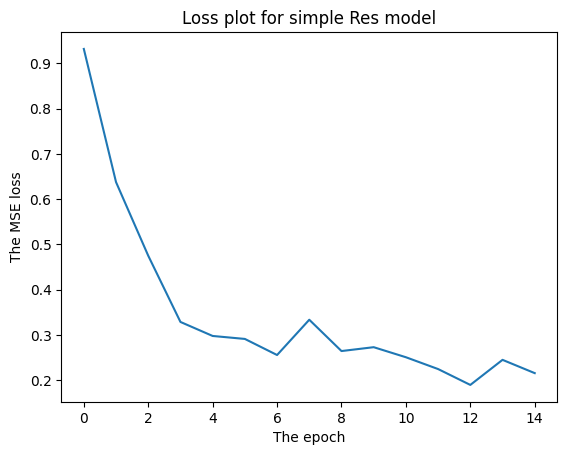

In [14]:
plt.plot(loss_res)
plt.title("Loss plot for simple Res model")
plt.xlabel("The epoch")
plt.ylabel("The MSE loss")
plt.show()

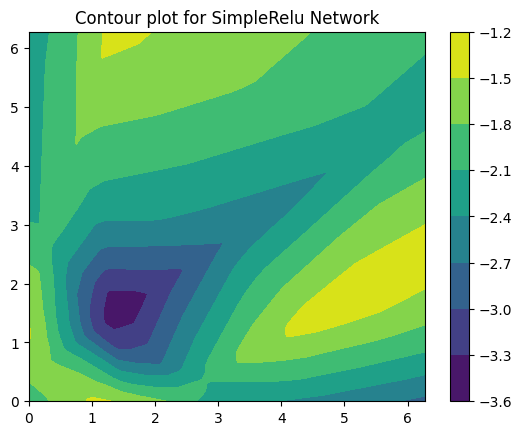

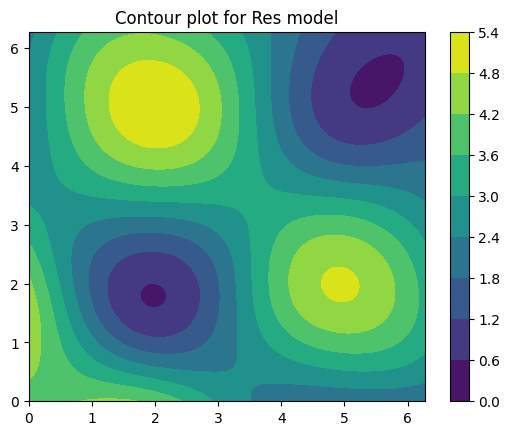

In [19]:
model.to("cpu")
model_res.to("cpu")
model.eval()
model_res.eval()

with torch.no_grad():
    plot_contour(model, "Contour plot for SimpleRelu Network")
    plot_contour(model_res, "Contour plot for Res model")

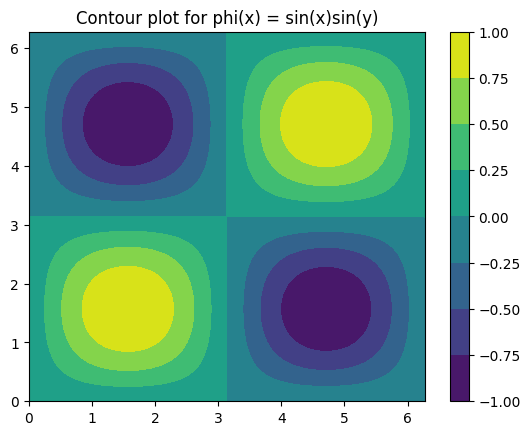

In [20]:
plot_contour(phi)